# Evaluation

## Preamble

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import gc
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.externals import joblib

In [3]:
import sys
sys.path.append('../src/')

import evaluation
import load_wdvd

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [5]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Load Data

In [6]:
PATH_FEATURES = '../../data/features/'

In [7]:
PATH_CLASSIFICATION = '../../data/classification/'

In [8]:
FILE_WDVD_TEST   = PATH_CLASSIFICATION + 'TEST_WDVD.csv.bz2'
FILE_ORES_TEST   = PATH_CLASSIFICATION + 'TEST_ORES.csv.bz2'
FILE_FILTER_TEST = PATH_CLASSIFICATION + 'TEST_FILTER.csv.bz2'

FILE_WDVD_VAL    = PATH_CLASSIFICATION + 'VALIDATION_WDVD.csv.bz2'
FILE_ORES_VAL    = PATH_CLASSIFICATION + 'VALIDATION_ORES.csv.bz2'
FILE_FILTER_VAL  = PATH_CLASSIFICATION + 'VALIDATION_FILTER.csv.bz2'

In [9]:
FILE_FAIR_E_TEST           = PATH_CLASSIFICATION + 'TEST_FAIR_E.csv.bz2'
FILE_FAIR_S_TEST           = PATH_CLASSIFICATION + 'TEST_FAIR_S.csv.bz2'

In [10]:
FILE_WDVD_WEIGHTED1_TEST = PATH_CLASSIFICATION + 'TEST_WDVD_WEIGHTED1.csv.bz2'
FILE_WDVD_WEIGHTED2_TEST = PATH_CLASSIFICATION + 'TEST_WDVD_WEIGHTED2.csv.bz2'

In [11]:
FILE_FAIR_S_FEATURE_OPTIMIZATION = PATH_CLASSIFICATION + 'fair-s-feature-optimization.csv'

In [12]:
FILE_ANNOTATIONS = '../../data/corpus-validity/wdvc16_annotations.csv'

In [13]:
OUTPUT_DIR = '../../data/classification/'

### Load Dataframe

In [14]:
fields = ['revisionId', 'isEditingTool']

dtype = {
    'revisionId': np.int,
    'isEditingTool': np.bool,
    'subject': np.int,
    'predicate': np.int,
    'object': np.int,
    'superSubject': np.int,
    'superObject': np.int,
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df_train = pd.read_csv(PATH_FEATURES + '/training/features.csv.bz2', index_col=0, usecols=fields, dtype=dtype)
    df_val = pd.read_csv(PATH_FEATURES + '/validation/features.csv.bz2', index_col=0, usecols=fields, dtype=dtype)
    df_test = pd.read_csv(PATH_FEATURES + '/test/features.csv.bz2', index_col=0, usecols=fields, dtype=dtype)

len(df_train)
len(df_val)
len(df_test)

24280578

1703987

2827193

### Load WDVD Features

In [15]:
df_wdvd = load_wdvd.load_df_wdvd()

In [16]:
df_wdvd.loc[df_train.index, 'isEditingTool'] = df_train['isEditingTool']
df_wdvd.loc[df_val.index, 'isEditingTool'] = df_val['isEditingTool']
df_wdvd.loc[df_test.index, 'isEditingTool'] = df_test['isEditingTool']

In [17]:
df_train = df_wdvd.loc[df_train.index]
df_val   = df_wdvd.loc[df_val.index]
df_test  = df_wdvd.loc[df_test.index]

mask_nosat_train = ~df_train['isEditingTool'].values.astype(np.bool)
mask_nosat_val   = ~df_val['isEditingTool'].values.astype(np.bool)
mask_nosat_test  = ~df_test['isEditingTool'].values.astype(np.bool)

df_train = df_train.loc[mask_nosat_train]
df_val = df_val.loc[mask_nosat_val]
df_test = df_test.loc[mask_nosat_test]

In [18]:
len(df_train)
len(df_val)
len(df_test)

5890968

550798

560524

In [19]:
gc.collect()
del(df_wdvd)
gc.collect()

1201813

107

### Load Baselines

In [20]:
WDVD_VAL         = pd.read_csv(FILE_WDVD_VAL, compression='bz2', index_col=0)
ORES_VAL         = pd.read_csv(FILE_ORES_VAL, compression='bz2', index_col=0)
FILTER_VAL       = pd.read_csv(FILE_FILTER_VAL, compression='bz2', index_col=0)
WDVD_TEST        = pd.read_csv(FILE_WDVD_TEST, compression='bz2', index_col=0)
ORES_TEST        = pd.read_csv(FILE_ORES_TEST, compression='bz2', index_col=0)
FILTER_TEST      = pd.read_csv(FILE_FILTER_TEST, compression='bz2', index_col=0)

In [21]:
df_val['WDVD']    = WDVD_VAL
df_val['ORES']    = ORES_VAL
df_val['FILTER']  = FILTER_VAL

df_test['WDVD']   = WDVD_TEST
df_test['ORES']   = ORES_TEST
df_test['FILTER'] = FILTER_TEST

In [22]:
WDVD_VAL         = WDVD_VAL.values
ORES_VAL         = ORES_VAL.values
FILTER_VAL       = FILTER_VAL.values
WDVD_TEST        = WDVD_TEST.values
ORES_TEST        = ORES_TEST.values
FILTER_TEST      = FILTER_TEST.values

In [23]:
WDVD_WEIGHTED1_TEST = pd.read_csv(FILE_WDVD_WEIGHTED1_TEST, compression='bz2', index_col=0)
WDVD_WEIGHTED2_TEST = pd.read_csv(FILE_WDVD_WEIGHTED2_TEST, compression='bz2', index_col=0)

In [24]:
df_test['WDVD-WEIGHTED1']  = WDVD_WEIGHTED1_TEST
df_test['WDVD-WEIGHTED2']  = WDVD_WEIGHTED2_TEST

In [25]:
WDVD_WEIGHTED1_TEST = WDVD_WEIGHTED1_TEST.values
WDVD_WEIGHTED2_TEST = WDVD_WEIGHTED2_TEST.values

### Load FAIR

In [26]:
FAIR_E_TEST = pd.read_csv(FILE_FAIR_E_TEST, compression='bz2', index_col=0)
FAIR_S_TEST = pd.read_csv(FILE_FAIR_S_TEST, compression='bz2', index_col=0)

In [27]:
df_test['FAIR-E'] = FAIR_E_TEST
df_test['FAIR-S'] = FAIR_S_TEST

In [28]:
FAIR_E_TEST = FAIR_E_TEST.values
FAIR_S_TEST = FAIR_S_TEST.values

### Calibration

In [29]:
df_val['WDVD_CALIBRATED'] = evaluation.calibrate_scores(df_val['rollbackReverted'].values, WDVD_VAL)
df_test['WDVD_CALIBRATED'] = evaluation.calibrate_scores(df_test['rollbackReverted'].values, WDVD_TEST)
df_test['ORES_CALIBRATED'] = evaluation.calibrate_scores(df_test['rollbackReverted'].values, ORES_TEST)
df_test['FILTER_CALIBRATED'] = evaluation.calibrate_scores(df_test['rollbackReverted'].values, FILTER_TEST)
df_test['FAIR_E_CALIBRATED'] = evaluation.calibrate_scores(df_test['rollbackReverted'].values, FAIR_E_TEST)
df_test['FAIR_S_CALIBRATED'] = evaluation.calibrate_scores(df_test['rollbackReverted'].values, FAIR_S_TEST)

## Utils

In [30]:
def transform_linear(x, i):
    return x * (1 - i)


def transform_polynomial(x, i):
    return x ** i


def transform_fractional(x, i):
    return 1 / (1 - 0.5 * x ** i) - 1


def transform_exponential(x, i):
    return (i ** x - 1) / (i - 1)

In [31]:
def debias_scores(func, protected, scores, i):
    scores = scores.copy()
    scores[protected] = func(scores[protected], i)
    return scores

## Overview

In [32]:
df_test['FAIR-E + WDVD']    = 0.978 * FAIR_E_TEST + (1 - 0.978) * WDVD_TEST
df_test['FAIR-E + ORES']    = 0.968 * FAIR_E_TEST + (1 - 0.968) * ORES_TEST
df_test['FAIR-E + FILTER']  = 0.973 * FAIR_E_TEST + (1 - 0.973) * FILTER_TEST

In [33]:
df_test['WDVD-POST1'] = debias_scores(transform_polynomial, ~df_test['isRegisteredUser'], df_test['WDVD'].values, 3.88)
df_test['WDVD-POST2'] = debias_scores(transform_polynomial, ~df_test['isRegisteredUser'], df_test['WDVD'].values, 3.22)

In [34]:
def overview(df, models):
    metrics = pd.DataFrame()
    for column in models:
        y = df['rollbackReverted'].values
        proba = df[column].values
        protected = ~df['isRegisteredUser'].values

        metrics_performance = evaluation.evaluate_proba_performance(y, proba, index=column)
        metrics_bias = evaluation.evaluate_proba_bias(y, protected, proba, index=column)
        metrics_cur = pd.concat([metrics_performance, metrics_bias], axis=1, keys=['Performance', 'Bias'])
        metrics = metrics.append(metrics_cur)
    return metrics

In [35]:
models = [
    'FAIR-E',
    'FAIR-S',
    'WDVD-POST1',
    'WDVD-POST2',
    'WDVD-WEIGHTED1',
    'WDVD-WEIGHTED2',
    'FAIR-E + WDVD',
    'FAIR-E + ORES',
    'FAIR-E + FILTER',
    'WDVD',
    'ORES',
    'FILTER']

statistics = overview(df_test, models)
statistics

Performance                                               Bias            \
                  n_samples n_positive       ACC        PR       ROC n_samples    p_mean   
FAIR-E               560524       2429  0.995656  0.177000  0.864932    560524  0.037805   
FAIR-S               560524       2429  0.995827  0.316492  0.963333    560524  0.066263   
WDVD-POST1           560524       2429  0.995667  0.230088  0.965846    560524  0.035000   
WDVD-POST2           560524       2429  0.995667  0.339517  0.975849    560524  0.062235   
WDVD-WEIGHTED1       560524       2429  0.993988  0.160444  0.963498    560524  0.035996   
WDVD-WEIGHTED2       560524       2429  0.995017  0.314350  0.972571    560524  0.064599   
FAIR-E + WDVD        560524       2429  0.995661  0.229031  0.973600    560524  0.057308   
FAIR-E + ORES        560524       2429  0.995661  0.238135  0.966726    560524  0.058403   
FAIR-E + FILTER      560524       2429  0.995661  0.223923  0.953105    560524  0.056865   
WDVD                 560524       2429  0.996193  0.546764  0.989712    560524  0.176391   
ORES                 560524       2429  0.995918  0.433969  0.964806    560524  0.154403   
FILTER               560524       2429  0.995979  0.301973  0.923834    560524  0.128555   

                                                                      
                  np_mean   bp_mean  bnp_mean score_diff score_ratio  
FAIR-E           0.003581  0.019760  0.003524   0.016235    5.606960  
FAIR-S           0.002940  0.033748  0.002842   0.030906   11.874172  
WDVD-POST1       0.003644  0.018108  0.003437   0.014672    5.269351  
WDVD-POST2       0.003031  0.032864  0.002789   0.030075   11.782039  
WDVD-WEIGHTED1   0.003621  0.018935  0.003552   0.015384    5.331320  
WDVD-WEIGHTED2   0.002978  0.033117  0.002870   0.030247   11.537414  
FAIR-E + WDVD    0.003142  0.035862  0.003073   0.032789   11.670200  
FAIR-E + ORES    0.003117  0.036083  0.003046   0.033037   11.846413  
FAIR-E + FILTER  0.003152  0.036347  0.003079   0.033269   11.806662  
WDVD             0.000463  0.121455  0.000391   0.121065  310.721375  
ORES             0.000958  0.114430  0.000860   0.113571  133.131643  
FILTER           0.001539  0.097819  0.001413   0.096406   69.223894

In [36]:
formatters = {
    ('Performance', 'PR'): '{:.3f}'.format,
    ('Performance', 'ROC'): '{:.3f}'.format,
    ('Bias', 'score_diff'): '{:.3f}'.format,
    ('Bias', 'score_ratio'): '{:.1f}'.format
}

statistics = statistics[[
    ('Performance', 'PR'),
    ('Performance', 'ROC'),
    ('Bias', 'score_diff'),
    ('Bias', 'score_ratio')
]]

statistics.to_latex(OUTPUT_DIR + 'table-evaluation-overview.tex', formatters=formatters)
statistics.style.format(formatters)

## Bias Table

In [37]:
def evaluate_biases(df, scores, name):
    scores = evaluation.calibrate_scores(df['rollbackReverted'].values, scores.values)

    mask_benign = (df['rollbackReverted'] == 0).values
    mask_anon =  (df['isRegisteredUser'] == 0).values

    df_result = pd.DataFrame()

    benign_protected_mean = np.mean(scores[~df['isRegisteredUser'].values & mask_benign])
    benign_unprotected_mean = np.mean(scores[df['isRegisteredUser'].values  & mask_benign])

    df_result.loc['Count', name] = '{:,.0f}'.format(len(scores))
    df_result.loc['Benign Anon', name] = '{:.4f}'.format(benign_protected_mean)
    df_result.loc['Benign Reg', name]  = '{:.4f}'.format(benign_unprotected_mean)

    diff = benign_protected_mean - benign_unprotected_mean
    ratio = benign_protected_mean / benign_unprotected_mean

    df_result.loc['Benign Anon Diff'] = '{:.3f}'.format(diff)
    df_result.loc['Bening Anon Ratio'] = '{:.1f}'.format(ratio)

    for seconds in [3600, 86400, 604800]:
        benign_protected_mean =\
            np.mean(scores[(df['userSecondsSinceFirstRevision'].values < seconds) & mask_benign])
        benign_unprotected_mean =\
            np.mean(scores[(df['userSecondsSinceFirstRevision'].values >= seconds) & mask_benign])

        diff = benign_protected_mean - benign_unprotected_mean
        ratio = benign_protected_mean / benign_unprotected_mean

        df_result.loc['{} diff'.format(seconds), name]  = '{:.3f}'.format(diff)
        df_result.loc['{} ratio'.format(seconds), name] = '{:.1f}'.format(ratio)

    countries = ['US', 'MX', 'ES', 'JP']
    # countries = list(df['userCountryCode'].unique())

    for country in countries:
        benign_protected_mean =\
            np.mean(scores[(df['userCountryCode'].values == country) & mask_benign & mask_anon])
        benign_unprotected_mean =\
            np.mean(scores[(df['userCountryCode'].values != country) & mask_benign & mask_anon])

        diff = benign_protected_mean - benign_unprotected_mean
        ratio = benign_protected_mean / benign_unprotected_mean

        df_result.loc[str(country) + ' diff']  = '{:.3f}'.format(diff)
        df_result.loc[str(country) + ' ratio'] = '{:.1f}'.format(ratio)

    return df_result

In [38]:
def evaluate_all_biases(df, models):
    df_result = pd.DataFrame()
    for model in models:
        df_result_cur = evaluate_biases(df, df[model], name=model)
        df_result = df_result.join(df_result_cur, how='outer')
    return df_result

In [39]:
models = ['WDVD', 'ORES', 'FILTER', 'FAIR-S']
statistics = evaluate_all_biases(df_test, models)
statistics.to_latex(OUTPUT_DIR + 'table-bias-models.tex')
display(statistics)

,WDVD,ORES,FILTER,FAIR-S
Count,"560,524","560,524","560,524","560,524"
Benign Anon,0.1215,0.1144,0.0978,0.0337
Benign Reg,0.0004,0.0009,0.0014,0.0028
Benign Anon Diff,0.121,0.114,0.096,0.031
Bening Anon Ratio,310.7,133.1,69.2,11.9
3600 diff,0.138,0.109,0.109,0.037
3600 ratio,172.7,72.4,63.7,13.5
86400 diff,0.101,0.085,0.085,0.026
86400 ratio,170.9,68.3,58.2,10.2
604800 diff,0.060,0.053,0.053,0.015


## Pareto Front

In [40]:
def pareto_frontier(Xs, Ys, Cs, Ls):
    myList = sorted([[Xs[i], Ys[i], Cs[i], Ls[i]] for i in range(len(Xs))])
    p_front = [myList[0]]
    for pair in myList[1:]:
        if pair[1] >= p_front[-1][1]:
            p_front.append(pair)

    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    p_color  = [pair[2] for pair in p_front]
    p_label  = [pair[3] for pair in p_front]
    return p_frontX, p_frontY, p_color, p_label

In [41]:
def plot_pareto(ax, df, xlim=None, ylim=None):
    base_color = 'darkorange'
    mapping = {'Remove': 'red', 'Add': 'green', 'None': base_color}

    x = df[('Bias', 'score_ratio')].values
    y = df[('Performance', 'ROC')].values
    c = pd.Series(df.index.get_level_values(0), index=df.index).map(mapping).values
    l = pd.Series(df.index.get_level_values(1), index=df.index).values

    ax.scatter(x, y, c=c, zorder=2)

    p_x, p_y, p_c, p_l = pareto_frontier(x, y, c, l)

    display(pd.DataFrame({'x': p_x, 'y': p_y, 'c': p_c, 'l': p_l}))

    plt.plot(p_x, p_y, 'k--', zorder=1)

    base_index = np.where(c == base_color)

    ax.annotate('FAIR-S', xy=(x[base_index], y[base_index]),
                xytext=(5, 0), textcoords='offset points',)

    ax.set_xlabel('Bias')
    ax.set_ylabel('ROC-AUC')

    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])

    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

In [42]:
df_pareto = pd.read_csv(FILE_FAIR_S_FEATURE_OPTIMIZATION, header=[0, 1], index_col=[0, 1])

,c,l,x,y
0,red,objectPredicateCumFrequency,4.546660,0.953777
1,green,subjectPredicateFrequency,4.792631,0.956148
2,green,editCommentTailLength,6.208569,0.956612
3,green,subjectNumberOfQualifiers,6.252951,0.960393
4,darkorange,Baseline,6.916121,0.960936


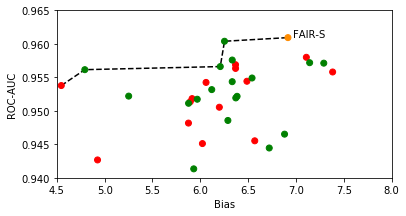

In [43]:
fig, ax = plt.subplots()

ylim = [0.94, 0.965]
xlim = [4.5, 8.0]
plot_pareto(ax, df_pareto, xlim=xlim, ylim=ylim)

xdim = ylim[1] - ylim[0]
ydim = xlim[1] - xlim[0]
ratio_dim = ydim / xdim  * 0.5
fig.axes[0].set_aspect(ratio_dim, adjustable='box')

fig.savefig(OUTPUT_DIR + '/plot-performance-bias-pareto.pdf', transparent=True, bbox_inches='tight')

## WDVD Postprocessing

In [44]:
def evaluate(df, column):
    y = df['rollbackReverted'].values
    protected = ~df['isRegisteredUser'].values
    proba = df[column].values

    return evaluation.evaluate_proba_performance_bias(y, protected, proba)

In [45]:
def debias_single(func, column, i, calibrate=False):
    if calibrate:
        scores = evaluation.calibrate_scores(df_test['rollbackReverted'].values, df_test[column].values)
    else:
        scores = df_test[column].values
    protected = ~df_test['isRegisteredUser'].values
    df_test['TMP'] = debias_scores(func, protected, scores, i)
    return evaluate(df_test, 'TMP')

In [46]:
def debias(func, column, i1, i2):
    metrics1 = debias_single(func, column, i1).iloc[:, [3, 4, -2, -1]]
    metrics1['i'] = i1
    metrics2 = debias_single(func, column, i2).iloc[:, [3, 4, -2, -1]]
    metrics2['i'] = i2
    metrics = pd.concat([metrics1, metrics2])
    metrics.set_index('i', inplace=True)
    return metrics

In [47]:
debias(transform_polynomial, 'WDVD', 3.88, 3.22)

Performance                 Bias            
              PR       ROC score_diff score_ratio
i                                                
3.88    0.230088  0.965846   0.014672    5.269351
3.22    0.339517  0.975849   0.030075   11.782039

### Further  Experiments: Transformation Function

In [48]:
debias(transform_linear, 'WDVD', 0.97, 0.92)

Performance                 Bias            
              PR       ROC score_diff score_ratio
i                                                
0.97    0.109147  0.963048   0.014939    5.044994
0.92    0.196309  0.981369   0.032511   11.714577

In [49]:
debias(transform_fractional, 'WDVD', 3.2, 2.6)

Performance                 Bias            
             PR       ROC score_diff score_ratio
i                                               
3.2    0.207671  0.968043   0.015873    5.606399
2.6    0.305498  0.977781   0.030021   11.511626

In [50]:
debias(transform_exponential, 'WDVD', 500, 150)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


Performance                 Bias            
             PR       ROC score_diff score_ratio
i                                               
500    0.173565  0.970370   0.015147    5.251699
150    0.277747  0.981444   0.030159   11.286735

### Further Experiments: Calibration

In [51]:
debias(transform_linear, 'WDVD_CALIBRATED', 0.998, 0.9973)

Performance                 Bias            
                PR       ROC score_diff score_ratio
i                                                  
0.9980    0.133493  0.927169   0.015021    5.347003
0.9973    0.138592  0.931295   0.016887    5.981496

In [52]:
debias(transform_polynomial, 'WDVD_CALIBRATED', 8.5, 6.5)

Performance                 Bias            
             PR       ROC score_diff score_ratio
i                                               
8.5    0.209495  0.779839   0.012030    4.550566
6.5    0.294219  0.847744   0.016337    6.173246

## Manual Annotation

### Generate Samples

In [53]:
N_SAMPLES = 250

In [54]:
df_samples = df_test\
    .reset_index()\
    .groupby(by=['rollbackReverted', 'isRegisteredUser'])['revisionId']\
    .apply(lambda x: x.sample(N_SAMPLES, random_state=1))

In [55]:
df_samples.head()

rollbackReverted  isRegisteredUser        
False             False             86186     334831946
                                    354309    345011260
                                    555651    352481067
                                    275314    341791516
                                    560279    352668947
Name: revisionId, dtype: int64

In [56]:
len(df_test)

560524

In [57]:
df_samples.to_csv(OUTPUT_DIR + 'samples.csv')

### Evaluate Samples

In [58]:
df_annotation = pd.read_csv(FILE_ANNOTATIONS, index_col=0, header=None)
df_annotation.columns = ['annotation']
df_annotation['annotation'] = df_annotation['annotation'].astype(np.bool)
samples = df_annotation.index.values

In [59]:
df_sample_weight = df_test.join(df_annotation, how='left')\
    .groupby(by=['rollbackReverted', 'isRegisteredUser'])['annotation']\
    .transform(lambda x: len(x) / x.count())  # strata weight len(x) divided by number of samples in this strata

df_annotation['sample_weight'] = df_sample_weight

In [60]:
df_annotation['rollbackReverted'] = df_test['rollbackReverted'].copy()
df_annotation['isRegisteredUser'] = df_test['isRegisteredUser'].copy()
df_annotation['WDVD_CALIBRATED'] = df_test['WDVD_CALIBRATED'].copy()
df_annotation['FAIR-S'] = df_test['FAIR-S'].copy()
df_annotation['property'] = df_test['property'].copy()
df_annotation['revisionAction'] = df_test['revisionAction'].copy()
df_annotation['revisionSubaction'] = df_test['revisionSubaction'].copy()

In [61]:
# Estimated bias based on golden data
evaluation.evaluate_proba_performance_bias(
    df_annotation['annotation'].values,
    ~df_annotation['isRegisteredUser'].values,
    df_annotation['WDVD_CALIBRATED'].values,
    sample_weight=df_annotation['sample_weight'].values,
    calibrate=False
)

Performance                                             Bias                                \
   n_samples n_positive     ACC        PR       ROC n_samples    p_mean   np_mean   bp_mean   
        1000        524  0.9507  0.176513  0.613314      1000  0.180641  0.000638  0.083454   

                                   
  bnp_mean score_diff score_ratio  
  0.000582   0.082872  143.444508

In [62]:
table = df_annotation\
    .groupby(by=['isRegisteredUser', 'rollbackReverted', 'sample_weight', 'annotation'])['WDVD_CALIBRATED']\
    .agg(['count', 'mean'])
table = table.reset_index()
table.rename(columns={'weight': 'sample_weight'}, inplace=True)
table['weight'] = table['count'] * table['sample_weight']

table['weight'] = table.loc[table['annotation'] == False, 'weight']\
    / table.loc[table['annotation'] == False, 'weight'].sum()

table.loc[table['isRegisteredUser'] == False, 'weight'] /= table.loc[table['isRegisteredUser'] == False, 'weight'].sum()
table.loc[table['isRegisteredUser'] == True, 'weight'] /= table.loc[table['isRegisteredUser'] == True, 'weight'].sum()

table = table.merge(
    df_test.groupby(['isRegisteredUser', 'rollbackReverted']).size().rename('n_corpus').to_frame().reset_index(),
    on=['isRegisteredUser', 'rollbackReverted'])

table['weighted_sum'] = table['weight'] * table['mean']


table = table[['isRegisteredUser', 'rollbackReverted', 'n_corpus', 'annotation', 'count', 'weight', 'mean', 'weighted_sum']]\
    .sort_values(['isRegisteredUser', 'rollbackReverted'], ascending=[True, False])

formatters = {
    'n_corpus': '{:,.0f}'.format,
    'mean': '{:.6f}'.format,
    'weight': '{:.2%}'.format,
    'weighted_sum': '{:.6f}'.format
}

table.to_latex(OUTPUT_DIR + 'table-dataset-wdvd-bias-validation.tex', formatters=formatters)

table.style.format(formatters)

,isRegisteredUser,rollbackReverted,n_corpus,annotation,count,weight,mean,weighted_sum
2,False,True,"2,061",False,19,1.98%,0.279443,0.005526
3,False,True,"2,061",True,231,nan%,0.460118,nan
0,False,False,"10,270",False,189,98.02%,0.079500,0.077928
1,False,False,"10,270",True,61,nan%,0.275444,nan
6,True,True,368,False,29,0.01%,0.032105,0.000003
7,True,True,368,True,221,nan%,0.120770,nan
4,True,False,"547,825",False,239,99.99%,0.000579,0.000579
5,True,False,"547,825",True,11,nan%,0.000231,nan


In [63]:
benign_protected   = table[(table['annotation'] == 0) & (table['isRegisteredUser'] == False)]
benign_unprotected = table[(table['annotation'] == 0) & (table['isRegisteredUser'] == True)]

benign_protected_mean = (benign_protected['mean'] * benign_protected['weight']).sum() / benign_protected['weight'].sum()

benign_unprotected_mean = (benign_unprotected['mean'] * benign_unprotected['weight']).sum() / benign_unprotected['weight'].sum()

benign_protected_mean
benign_unprotected_mean
benign_protected_mean - benign_unprotected_mean
benign_protected_mean / benign_unprotected_mean

0.083453723537639551

0.00058178402747689816

0.082871939510162654

143.44450792085965

### Error Analysis

In [64]:
# threshold on sample with annotation ground truth
threshold = df_annotation['FAIR-S'].quantile(1 - df_annotation['annotation'].mean())
threshold
(df_annotation['FAIR-S'] > threshold).sum()
(df_annotation['FAIR-S'] > threshold).mean()

0.0065616099499166

524

0.52400000000000002

In [65]:
df_annotation['decision'] = df_annotation['FAIR-S'] > threshold

In [66]:
df_tmp = pd.crosstab(df_annotation['isRegisteredUser'], [df_annotation['annotation'], df_annotation['decision']])
df_tmp.columns.set_levels([[str(y) for y in x] for x in df_tmp.columns.levels], inplace=True)
df_tmp = df_tmp.loc[:, [('True', 'True'), ('True', 'False'), ('False', 'True'), ('False', 'False')]]
df_tmp.to_latex(OUTPUT_DIR + 'table-error-analysis.tex')
df_tmp

annotation       True       False      
decision         True False  True False
isRegisteredUser                       
False             250    42    73   135
True              173    59    28   240

In [67]:
df_tmp = df_annotation[~df_annotation['isRegisteredUser'] & ~df_annotation['annotation'] & df_annotation['decision']]
len(df_tmp)

73

In [68]:
df_tmp['property'].value_counts().to_frame().head()

,property
106.0,10
31.0,8
21.0,6
27.0,6
6.0,3


In [69]:
df_tmp['revisionSubaction'].value_counts().to_frame().head()

,revisionSubaction
update,53
remove,11
create,9
set-badges,0
update|2|srwiki|srwiki,0


## Debiasing via Combining Models

In [70]:
def get_metrics(df, SCORES1, SCORES2):
    y = df['rollbackReverted'].values
    protected = ~df['isRegisteredUser'].values

    weights = np.hstack([np.linspace(0.9, 1, num=101)])

    metrics_list = []
    for weight in weights:
        TMP_TEST  = weight * SCORES1 + (1 - weight) * SCORES2
        metrics_cur = joblib.delayed(evaluation.evaluate_proba_performance_bias)(y, protected, TMP_TEST, index=str(weight))
        metrics_list.append(metrics_cur)

    metrics_list = joblib.Parallel(n_jobs=8, verbose=0)(metrics_list)
    metrics = pd.concat(metrics_list)

    return metrics

In [71]:
get_metrics(df_test, FAIR_E_TEST, WDVD_TEST)

Performance                                               Bias                      \
        n_samples n_positive       ACC        PR       ROC n_samples    p_mean   np_mean   
0.9        560524       2429  0.995683  0.330881  0.986559    560524  0.100831  0.002163   
0.901      560524       2429  0.995683  0.329966  0.986522    560524  0.100347  0.002174   
0.902      560524       2429  0.995683  0.329037  0.986485    560524  0.099979  0.002182   
0.903      560524       2429  0.995683  0.328079  0.986447    560524  0.099589  0.002191   
0.904      560524       2429  0.995684  0.327150  0.986407    560524  0.099154  0.002201   
0.905      560524       2429  0.995684  0.326187  0.986370    560524  0.098726  0.002210   
0.906      560524       2429  0.995684  0.325279  0.986328    560524  0.098348  0.002219   
0.907      560524       2429  0.995684  0.324319  0.986288    560524  0.098030  0.002226   
0.908      560524       2429  0.995684  0.323340  0.986187    560524  0.097655  0.002234   
0.909      560524       2429  0.995684  0.322356  0.986148    560524  0.097277  0.002243   
0.91       560524       2429  0.995684  0.321410  0.986105    560524  0.096969  0.002250   
0.911      560524       2429  0.995684  0.320449  0.986063    560524  0.096592  0.002258   
0.912      560524       2429  0.995683  0.319455  0.986022    560524  0.096241  0.002266   
0.913      560524       2429  0.995683  0.318480  0.985980    560524  0.095880  0.002274   
0.914      560524       2429  0.995683  0.317478  0.985922    560524  0.095300  0.002287   
0.915      560524       2429  0.995683  0.316475  0.985877    560524  0.095028  0.002293   
0.916      560524       2429  0.995683  0.315491  0.985832    560524  0.094553  0.002304   
0.917      560524       2429  0.995683  0.314417  0.985781    560524  0.094048  0.002315   
0.918      560524       2429  0.995683  0.313499  0.985732    560524  0.093597  0.002326   
0.919      560524       2429  0.995683  0.312419  0.985683    560524  0.093131  0.002336   
0.92       560524       2429  0.995683  0.311350  0.985631    560524  0.092776  0.002344   
0.921      560524       2429  0.995683  0.310286  0.985523    560524  0.092357  0.002353   
0.922      560524       2429  0.995683  0.309207  0.985469    560524  0.091965  0.002362   
0.923      560524       2429  0.995683  0.308126  0.985418    560524  0.091524  0.002372   
0.924      560524       2429  0.995683  0.307025  0.985361    560524  0.091031  0.002383   
0.925      560524       2429  0.995683  0.305890  0.985304    560524  0.090676  0.002391   
0.926      560524       2429  0.995681  0.304754  0.985243    560524  0.090266  0.002400   
0.927      560524       2429  0.995679  0.303659  0.985184    560524  0.089735  0.002412   
0.928      560524       2429  0.995679  0.302541  0.985122    560524  0.089160  0.002425   
0.929      560524       2429  0.995679  0.301407  0.985061    560524  0.088627  0.002437   
0.93       560524       2429  0.995675  0.300251  0.984935    560524  0.088227  0.002446   
0.931      560524       2429  0.995675  0.299075  0.984872    560524  0.087680  0.002459   
0.932      560524       2429  0.995675  0.297902  0.984803    560524  0.087223  0.002469   
0.933      560524       2429  0.995675  0.296745  0.984733    560524  0.086620  0.002483   
0.934      560524       2429  0.995677  0.295582  0.984661    560524  0.086116  0.002494   
0.935      560524       2429  0.995675  0.294430  0.984588    560524  0.085638  0.002505   
0.936      560524       2429  0.995675  0.293248  0.984515    560524  0.085067  0.002517   
0.937      560524       2429  0.995675  0.292010  0.984436    560524  0.084453  0.002531   
0.938      560524       2429  0.995675  0.290801  0.984299    560524  0.083950  0.002543   
0.939      560524       2429  0.995675  0.289611  0.984220    560524  0.083375  0.002555   
0.94       560524       2429  0.995675  0.288336  0.984135    560524  0.082463  0.002576   
0.941      560524       2429  0.995674  0.287035  

In [72]:
get_metrics(df_test, FAIR_E_TEST, ORES_TEST)

Performance                                               Bias                      \
        n_samples n_positive       ACC        PR       ROC n_samples    p_mean   np_mean   
0.9        560524       2429  0.995674  0.310248  0.976646    560524  0.087163  0.002470   
0.901      560524       2429  0.995674  0.309323  0.976459    560524  0.087012  0.002474   
0.902      560524       2429  0.995674  0.308443  0.976345    560524  0.086724  0.002480   
0.903      560524       2429  0.995674  0.307621  0.976237    560524  0.086327  0.002489   
0.904      560524       2429  0.995675  0.306820  0.976194    560524  0.086168  0.002493   
0.905      560524       2429  0.995677  0.305963  0.976073    560524  0.085836  0.002500   
0.906      560524       2429  0.995677  0.305115  0.976033    560524  0.085512  0.002507   
0.907      560524       2429  0.995679  0.304282  0.975986    560524  0.085160  0.002515   
0.908      560524       2429  0.995679  0.303356  0.975942    560524  0.084743  0.002525   
0.909      560524       2429  0.995679  0.302518  0.975891    560524  0.084408  0.002532   
0.91       560524       2429  0.995679  0.301605  0.975695    560524  0.084054  0.002540   
0.911      560524       2429  0.995677  0.300674  0.975644    560524  0.083802  0.002546   
0.912      560524       2429  0.995677  0.299779  0.975593    560524  0.083564  0.002551   
0.913      560524       2429  0.995677  0.298964  0.975545    560524  0.083222  0.002559   
0.914      560524       2429  0.995679  0.298117  0.975499    560524  0.082890  0.002566   
0.915      560524       2429  0.995679  0.297210  0.975445    560524  0.082476  0.002576   
0.916      560524       2429  0.995679  0.296361  0.975393    560524  0.082239  0.002581   
0.917      560524       2429  0.995679  0.295433  0.975338    560524  0.081858  0.002590   
0.918      560524       2429  0.995679  0.294532  0.975286    560524  0.081464  0.002598   
0.919      560524       2429  0.995679  0.293565  0.975228    560524  0.081021  0.002608   
0.92       560524       2429  0.995681  0.292638  0.975164    560524  0.080667  0.002616   
0.921      560524       2429  0.995681  0.291720  0.975103    560524  0.080286  0.002625   
0.922      560524       2429  0.995681  0.290857  0.975043    560524  0.079935  0.002633   
0.923      560524       2429  0.995681  0.289878  0.974976    560524  0.079598  0.002640   
0.924      560524       2429  0.995681  0.288949  0.974907    560524  0.079305  0.002647   
0.925      560524       2429  0.995681  0.288058  0.974842    560524  0.078826  0.002658   
0.926      560524       2429  0.995681  0.287084  0.974775    560524  0.078337  0.002669   
0.927      560524       2429  0.995677  0.286120  0.974707    560524  0.078023  0.002676   
0.928      560524       2429  0.995677  0.285204  0.974568    560524  0.077629  0.002685   
0.929      560524       2429  0.995677  0.284295  0.974501    560524  0.077303  0.002692   
0.93       560524       2429  0.995674  0.283309  0.974358    560524  0.076885  0.002701   
0.931      560524       2429  0.995674  0.282286  0.974136    560524  0.076516  0.002710   
0.932      560524       2429  0.995674  0.281339  0.974059    560524  0.076074  0.002720   
0.933      560524       2429  0.995674  0.280329  0.973983    560524  0.075716  0.002728   
0.934      560524       2429  0.995674  0.279385  0.973836    560524  0.075161  0.002740   
0.935      560524       2429  0.995672  0.278369  0.973612    560524  0.074744  0.002750   
0.936      560524       2429  0.995672  0.277290  0.973448    560524  0.074209  0.002762   
0.937      560524       2429  0.995672  0.276157  0.973276    560524  0.073880  0.002769   
0.938      560524       2429  0.995672  0.275109  0.973188    560524  0.073472  0.002778   
0.939      560524       2429  0.995672  0.274063  0.973097    560524  0.072955  0.002790   
0.94       560524       2429  0.995672  0.272995  0.972930    560524  0.072577  0.002798   
0.941      560524       2429  0.995672  0.271961  

In [73]:
get_metrics(df_test, FAIR_E_TEST, FILTER_TEST)

Performance                                               Bias                      \
        n_samples n_positive       ACC        PR       ROC n_samples    p_mean   np_mean   
0.9        560524       2429  0.995679  0.293447  0.958810    560524  0.086689  0.002481   
0.901      560524       2429  0.995679  0.292799  0.958787    560524  0.084982  0.002519   
0.902      560524       2429  0.995679  0.292046  0.958759    560524  0.086137  0.002493   
0.903      560524       2429  0.995683  0.291320  0.958735    560524  0.085902  0.002499   
0.904      560524       2429  0.995683  0.290632  0.958711    560524  0.085628  0.002505   
0.905      560524       2429  0.995683  0.289936  0.958686    560524  0.085468  0.002508   
0.906      560524       2429  0.995683  0.289149  0.958658    560524  0.085212  0.002514   
0.907      560524       2429  0.995683  0.288487  0.958631    560524  0.084985  0.002519   
0.908      560524       2429  0.995683  0.287764  0.958603    560524  0.084835  0.002523   
0.909      560524       2429  0.995683  0.287111  0.958578    560524  0.084624  0.002527   
0.91       560524       2429  0.995683  0.286417  0.958549    560524  0.084309  0.002534   
0.911      560524       2429  0.995681  0.285723  0.958522    560524  0.084018  0.002541   
0.912      560524       2429  0.995681  0.284897  0.958417    560524  0.083862  0.002545   
0.913      560524       2429  0.995681  0.284194  0.958389    560524  0.083466  0.002553   
0.914      560524       2429  0.995681  0.283461  0.958352    560524  0.083043  0.002563   
0.915      560524       2429  0.995681  0.282702  0.958313    560524  0.082799  0.002568   
0.916      560524       2429  0.995681  0.282044  0.958283    560524  0.082537  0.002574   
0.917      560524       2429  0.995681  0.281338  0.958252    560524  0.082182  0.002582   
0.918      560524       2429  0.995681  0.280467  0.958214    560524  0.081813  0.002591   
0.919      560524       2429  0.995681  0.279713  0.958181    560524  0.081618  0.002595   
0.92       560524       2429  0.995681  0.279003  0.958146    560524  0.081238  0.002604   
0.921      560524       2429  0.995681  0.278248  0.958109    560524  0.080945  0.002610   
0.922      560524       2429  0.995681  0.277579  0.958074    560524  0.080684  0.002616   
0.923      560524       2429  0.995681  0.276759  0.958033    560524  0.080360  0.002623   
0.924      560524       2429  0.995681  0.275930  0.957997    560524  0.080095  0.002629   
0.925      560524       2429  0.995681  0.275115  0.957949    560524  0.079286  0.002647   
0.926      560524       2429  0.995679  0.274199  0.957898    560524  0.078805  0.002658   
0.927      560524       2429  0.995679  0.273376  0.957849    560524  0.078413  0.002667   
0.928      560524       2429  0.995679  0.272484  0.957800    560524  0.077980  0.002677   
0.929      560524       2429  0.995679  0.271672  0.957753    560524  0.077664  0.002684   
0.93       560524       2429  0.995675  0.270730  0.957702    560524  0.077082  0.002697   
0.931      560524       2429  0.995675  0.269929  0.957657    560524  0.076795  0.002704   
0.932      560524       2429  0.995675  0.269024  0.957608    560524  0.076395  0.002712   
0.933      560524       2429  0.995675  0.268138  0.957557    560524  0.076100  0.002719   
0.934      560524       2429  0.995675  0.266786  0.957466    560524  0.075813  0.002726   
0.935      560524       2429  0.995674  0.265944  0.957411    560524  0.075419  0.002734   
0.936      560524       2429  0.995674  0.265046  0.957354    560524  0.074760  0.002749   
0.937      560524       2429  0.995674  0.264040  0.957291    560524  0.074166  0.002763   
0.938      560524       2429  0.995674  0.263146  0.957221    560524  0.073838  0.002770   
0.939      560524       2429  0.995674  0.262114  0.957148    560524  0.073415  0.002780   
0.94       560524       2429  0.995674  0.261217  0.957089    560524  0.073088  0.002787   
0.941      560524       2429  0.995674  0.260183  

## Debiasing via Post-Processing scores

In [74]:
def get_metrics2(df, scores, func):
    y = df['rollbackReverted'].values
    protected = ~df['isRegisteredUser'].values

    weights = np.hstack([np.linspace(3, 4, num=101)])

    metrics_list = []
    for weight in weights:
        cur_scores = scores.copy()
        cur_scores[protected] = func(cur_scores[protected], i=weight)

        metrics_cur = joblib.delayed(evaluation.evaluate_proba_performance_bias)(y, protected, cur_scores, index=str(weight))
        metrics_list.append(metrics_cur)

    metrics_list = joblib.Parallel(n_jobs=8, verbose=0)(metrics_list)
    metrics = pd.concat(metrics_list)

    return metrics

In [75]:
get_metrics2(df_test, WDVD_TEST, transform_polynomial)

Performance                                               Bias                                \
       n_samples n_positive       ACC        PR       ROC n_samples    p_mean   np_mean   bp_mean   
3.0       560524       2429  0.995667  0.382884  0.978666    560524  0.073659  0.002774  0.039300   
3.01      560524       2429  0.995667  0.381083  0.978567    560524  0.073378  0.002780  0.039161   
3.02      560524       2429  0.995667  0.378950  0.978495    560524  0.072950  0.002790  0.039008   
3.03      560524       2429  0.995667  0.377000  0.978273    560524  0.072455  0.002801  0.038637   
3.04      560524       2429  0.995667  0.375049  0.978184    560524  0.071780  0.002816  0.038178   
3.05      560524       2429  0.995667  0.373116  0.978038    560524  0.071097  0.002832  0.037727   
3.06      560524       2429  0.995667  0.370971  0.977925    560524  0.070380  0.002848  0.037404   
3.07      560524       2429  0.995667  0.368934  0.977650    560524  0.069871  0.002859  0.037093   
3.08      560524       2429  0.995667  0.366995  0.977574    560524  0.069389  0.002870  0.036794   
3.09      560524       2429  0.995667  0.365183  0.977471    560524  0.068927  0.002880  0.036627   
3.1       560524       2429  0.995667  0.363330  0.977376    560524  0.068511  0.002890  0.036453   
3.11      560524       2429  0.995667  0.361069  0.977193    560524  0.068113  0.002899  0.036192   
3.12      560524       2429  0.995667  0.359195  0.977103    560524  0.067928  0.002903  0.036276   
3.13      560524       2429  0.995667  0.357438  0.977033    560524  0.066828  0.002928  0.035463   
3.14      560524       2429  0.995667  0.355221  0.976884    560524  0.066612  0.002933  0.035444   
3.15      560524       2429  0.995667  0.353098  0.976694    560524  0.065608  0.002955  0.034879   
3.16      560524       2429  0.995667  0.351194  0.976592    560524  0.065551  0.002956  0.034822   
3.17      560524       2429  0.995667  0.349545  0.976517    560524  0.065116  0.002966  0.034549   
3.18      560524       2429  0.995667  0.347229  0.976409    560524  0.064299  0.002985  0.033991   
3.19      560524       2429  0.995667  0.345429  0.976194    560524  0.063895  0.002994  0.033713   
3.2       560524       2429  0.995667  0.343564  0.976078    560524  0.063395  0.003005  0.033349   
3.21      560524       2429  0.995667  0.341660  0.975963    560524  0.063253  0.003008  0.033442   
3.22      560524       2429  0.995667  0.339517  0.975849    560524  0.062235  0.003031  0.032864   
3.23      560524       2429  0.995667  0.337627  0.975729    560524  0.061035  0.003058  0.031989   
3.24      560524       2429  0.995667  0.335786  0.975576    560524  0.060944  0.003060  0.031932   
3.25      560524       2429  0.995667  0.333838  0.975426    560524  0.060867  0.003062  0.032049   
3.26      560524       2429  0.995667  0.331968  0.975360    560524  0.060749  0.003064  0.032041   
3.27      560524       2429  0.995667  0.330209  0.975255    560524  0.059973  0.003082  0.031429   
3.28      560524       2429  0.995667  0.328323  0.975102    560524  0.060473  0.003071  0.031911   
3.29      560524       2429  0.995667  0.326232  0.974992    560524  0.059488  0.003093  0.031448   
3.3       560524       2429  0.995667  0.324413  0.974859    560524  0.058823  0.003108  0.030965   
3.31      560524       2429  0.995667  0.322732  0.974749    560524  0.058051  0.003125  0.030659   
3.32      560524       2429  0.995667  0.320698  0.974524    560524  0.057974  0.003127  0.030575   
3.33      560524       2429  0.995667  0.318886  0.974428    560524  0.057610  0.003135  0.030367   
3.34      560524       2429  0.995667  0.317152  0.974247    560524  0.057359  0.003141  0.030252   
3.35      560524       2429  0.995667  0.315401  0.974095    560524  0.057119  0.003146  0.030098   
3.36      560524       2429  0.995667  0.313431  0.973878    560524  0.056232  0.003166  0.029529   
3.37      560524       2429  0.995667  0.311678  0.973749    56052

## Examples of WDVD Model Biases

In [76]:
def get_example(revision_anon, revision_reg):
    df_result = df_val.loc[[revision_anon, revision_reg], ['isRegisteredUser', 'WDVD_CALIBRATED']]
    score_anon = df_result.loc[revision_anon, 'WDVD_CALIBRATED']
    score_reg = df_result.loc[revision_reg, 'WDVD_CALIBRATED']
    df_result['diff'] = score_anon - score_reg
    df_result['ratio'] = score_anon / score_reg
    return df_result

In [77]:
# <Guido Westerwelle (Q19837), place of death (P20), Cologne (Q365)>
example1 = get_example(313453592, 313455460)
example1

,isRegisteredUser,WDVD_CALIBRATED,diff,ratio
revisionId,,,,
313453592,False,0.090838,0.090737,900.17093
313455460,True,0.000101,0.090737,900.17093


In [78]:
# <Alejandro Cuello (Q15924626), occupation (P106), actor (Q33999)>
example2 = get_example(325717121, 318143388)
example2

,isRegisteredUser,WDVD_CALIBRATED,diff,ratio
revisionId,,,,
325717121,False,0.291181,0.276319,19.592346
318143388,True,0.014862,0.276319,19.592346


In [79]:
examples = pd.concat([example1, example2])

formatters = {
    'WDVD_CALIBRATED': '{:.4f}'.format,
    'diff': '{:.4f}'.format,
    'ratio': '{:.1f}'.format
}

examples.to_latex(OUTPUT_DIR + 'table-bias-examples.tex', formatters=formatters)
examples.style.format(formatters)

,isRegisteredUser,WDVD_CALIBRATED,diff,ratio
revisionId,,,,
313453592,False,0.0908,0.0907,900.2
313455460,True,0.0001,0.0907,900.2
325717121,False,0.2912,0.2763,19.6
318143388,True,0.0149,0.2763,19.6


In [80]:
# <Duel (Q16522463), instance of (P31), short film (Q33999)>
get_example(325489118, 320573095)

,isRegisteredUser,WDVD_CALIBRATED,diff,ratio
revisionId,,,,
325489118,False,0.004111,0.00401,40.733987
320573095,True,0.000101,0.00401,40.733987


## Find Duplicate Triples by Anonymous/Registered Users

In [81]:
COLUMN_SUBSET = ['revisionAction', 'revisionSubaction', 'itemId', 'property', 'itemValue']

In [82]:
def remove_unused_categories(df):
    for column in df.select_dtypes(['category']):
        df.loc[:, column] = df.loc[:, column].cat.remove_unused_categories()

In [83]:
df_duplicates = df_val[df_val.duplicated(subset=COLUMN_SUBSET, keep=False)].copy()
df_duplicates.index.name = 'revisionId'

# reduce memory consumption
remove_unused_categories(df_duplicates)

len(df_duplicates)

26442

In [84]:
grouped = df_duplicates.groupby(COLUMN_SUBSET)['isRegisteredUser'].nunique()
grouped.name = 'nunique'
min2 = df_duplicates.groupby(COLUMN_SUBSET)['WDVD_CALIBRATED'].min()
min2.name = 'min'
max2 = df_duplicates.groupby(COLUMN_SUBSET)['WDVD_CALIBRATED'].max()
max2.name = 'max'

grouped = pd.concat([grouped, min2, max2], axis=1)
grouped['diff'] = grouped['max'] - grouped['min']
grouped['ratio'] = grouped['max'] / grouped['min']
grouped = grouped[grouped['nunique'] > 1]

In [85]:
merged = (df_duplicates.reset_index()
          .merge(grouped.reset_index(), how='right', on=COLUMN_SUBSET)
          .sort_values(['ratio'], ascending=False))

merged = merged[['revisionId'] + COLUMN_SUBSET + ['isRegisteredUser', 'rollbackReverted', 'WDVD', 'WDVD_CALIBRATED', 'min', 'max', 'diff', 'ratio']]

In [86]:
merged[(merged['revisionSubaction'] != 'update') & (merged['rollbackReverted'] == False)]

,revisionId,revisionAction,revisionSubaction,itemId,property,itemValue,isRegisteredUser,rollbackReverted,WDVD,WDVD_CALIBRATED,min,max,diff,ratio
43,313453592,wbsetclaim,create,58284,20.0,365.0,False,False,0.144531,0.090838,0.000101,0.090838,0.090737,900.170930
44,313455460,wbsetclaim,create,58284,20.0,365.0,True,False,0.000000,0.000101,0.000101,0.090838,0.090737,900.170930
153,320017072,wbsetclaim,create,1906804,27.0,159.0,False,False,0.164062,0.090838,0.000352,0.090838,0.090485,257.706252
154,325376163,wbsetclaim,create,1906804,27.0,159.0,True,False,0.001953,0.000352,0.000352,0.090838,0.090485,257.706252
195,324134667,wbremoveclaims,remove,7542,20.0,1992901.0,True,False,0.005859,0.001190,0.001190,0.291181,0.289992,244.721760
194,324133831,wbremoveclaims,remove,7542,20.0,1992901.0,False,False,0.273438,0.291181,0.001190,0.291181,0.289992,244.721760
155,320020649,wbremoveclaims,remove,1915174,6.0,23731820.0,True,False,0.015625,0.001190,0.001190,0.090838,0.089648,76.343951
156,320039145,wbremoveclaims,remove,1915174,6.0,23731820.0,False,False,0.147135,0.090838,0.001190,0.090838,0.089648,76.343951
92,317526543,wbsetclaim,create,23655565,1346.0,352080.0,True,False,0.000000,0.000101,0.000101,0.004111,0.004010,40.733987
160,325489118,wbsetclaim,create,15621914,31.0,24862.0,False,False,0.042969,0.004111,0.000101,0.004111,0.004010,40.733987
